# Описание проекта

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Дано: данные с параметрами добычи и очистки.

Описание данных: данные находятся в трёх файлах:

    • gold_recovery_train.csv — обучающая выборка;
    • gold_recovery_test.csv — тестовая выборка;
    • gold_recovery_full.csv — исходные данные
    
Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.


# Подготовка данных

## Открытие и изучение файлов

Импортируем необходимые библиотеки и инструменты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.dummy import DummyRegressor
import warnings
warnings.filterwarnings('ignore')

Загрузим данные и ознакомимся с ними

In [2]:
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')

df_test = pd.read_csv('/datasets/gold_recovery_test.csv')

df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
datasets = [df_train, df_test, df_full]

In [4]:
i = 0

names = ['Обучающая выборка', 'Тестовая выборка', 'Полная выборка']

for data in datasets:
    
    print()
    
    print(names[i])
    
    display(data.head())
    
    display(data.info())
    
    print('Количество дубликатов:', data.duplicated().sum())
    
    print('='*100)
    
    print()
    
    i += 1


Обучающая выборка


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

None

Количество дубликатов: 0


Тестовая выборка


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

None

Количество дубликатов: 0


Полная выборка


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

None

Количество дубликатов: 0



- Во всех датасетах присутствуют пропуски
- В тестовом датасете отсутствуют целевые признаки, а также меньшее количество признаков
- Во всех датасетах отсутствуют дубликаты

## Проверка верности расчёта эффективности обогащения

Для тестового датасета рассчитаем эффективность обогащения для этапа флотации и добавим получившиеся значения в столбец `rougher.output.recovery_check`

In [5]:
df_train['rougher.output.recovery_check'] = 100 * (df_train['rougher.output.concentrate_au'] * (df_train['rougher.input.feed_au'] - df_train['rougher.output.tail_au'])) / (df_train['rougher.input.feed_au'] * (df_train['rougher.output.concentrate_au'] - df_train['rougher.output.tail_au']))

Скопируем столбцы с расчитанным значением и признаком в отдельный датасет

In [6]:
df_temp = df_train[['rougher.output.recovery', 'rougher.output.recovery_check']]

Посмотрим информацию 

In [7]:
df_temp.head()

,rougher.output.recovery,rougher.output.recovery_check
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


In [8]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 2 columns):
rougher.output.recovery          14287 non-null float64
rougher.output.recovery_check    14577 non-null float64
dtypes: float64(2)
memory usage: 263.6 KB


Удалим из датасета строки, для которых пропущено значение признака

In [9]:
df_temp = df_temp.dropna()

Посчитаем MAE для расчётного значения и признака

In [10]:
mean_absolute_error(df_temp['rougher.output.recovery'], df_temp['rougher.output.recovery_check'])

1.0898633667227423e-14

Полученное значение близко к нулю, следовательно в обучающем датасете признак изначально был верно рассчитан

## Анализ признаков, недоступных в тестовой выборке

Посмотрим каких столбцов нет в тестовой выборке

In [11]:
df_train.columns.difference(df_test.columns)

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

Видим, что в тестовой выборке остутствуют признаки, которые могут быть доступны только после проведения технологических процессов 

## Предобработка данных

Переведём столбцы `date` в датасетах в формат даты

In [12]:
# Создадим функцию для перевода в формат даты

def format_to_date(data):
    
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%dT%H:%M:%S')

In [13]:
format_to_date(df_train)

format_to_date(df_test)

format_to_date(df_full)

Удалим из обучающей выборки столбец с рассчитанным в п.1.2 значением эффективности обогащения

In [14]:
df_train = df_train.drop(['rougher.output.recovery_check'], axis=1)

Заполним пропуски в выборках. Т.к. это технологический процесс, то часто соседние по времени параметры близки к друг другу, соответственно заполним пропуски предыдущими значениями

Сохраним названия столбцов обучающей и тестовой выборок

In [15]:
names = df_train.columns

names_test = df_test.columns

Заполним пропуски во всех выборках

In [16]:
for name in names:
    
    df_train[name] = df_train[name].fillna(method='ffill')   
    

In [17]:
for name in names_test:
    
    df_test[name] = df_test[name].fillna(method='ffill')

In [18]:
for name in names:
    
    df_full[name] = df_full[name].fillna(method='ffill')

## Выводы

- Эффективность обогащения была расчитана верно
- В тестовой выборке отсутствуют данные, доступные только после завершения технологических процессов, в том числе и целевые признаки
- Тестовую выборку надо будет дополнить целевыми признаками из исходной выборки
- Обучение моделей следует проводить только на признаках, присутствующих в тестовой выборке

# Анализ данных

## Анализ изменения концентрации металлов

Создадим функцию для вывода диаграмм размаха 

In [19]:
def boxplot(data, title):
    
    labels = ['Исходная смесь', 'Флотация', 'Этап 1', 'Этап 2']

    fig, ax = plt.subplots(figsize=(16, 6))
    
    ax.set_title(title, fontsize=18)
    
    bplot = ax.boxplot(data, patch_artist=True, labels=labels)

    colors = ['blue', 'lightblue', 'lightgreen', 'pink']

    for patch, color in zip(bplot['boxes'], colors):
        
            patch.set_facecolor(color)
        
    ax.yaxis.grid(True)

    plt.show()    
    

Построим диаграмму для золота

In [20]:
data_au = [df_train['rougher.input.feed_au'], df_train['rougher.output.concentrate_au'], df_train['primary_cleaner.output.concentrate_au'], 
           df_train['final.output.concentrate_au']]

title_au = 'Концентрация золота после разных этапов, %'

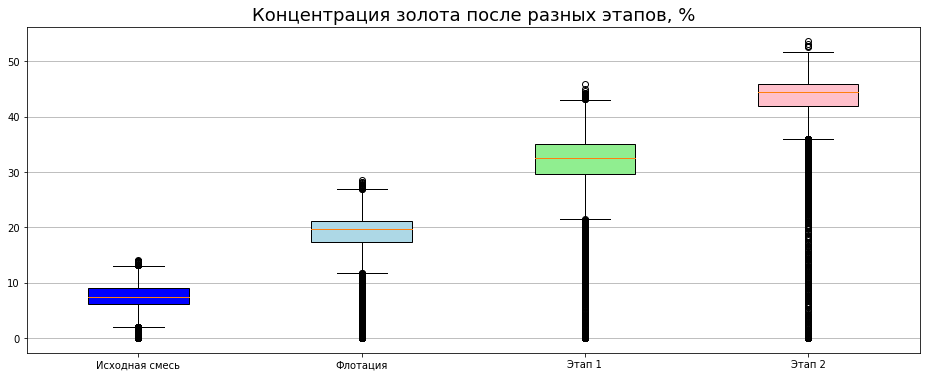

In [21]:
boxplot(data_au, title_au)

Концентрация золота с каждым этапом увеличивается

Построим диаграмму для серебра

In [22]:
data_ag = [df_train['rougher.input.feed_ag'], df_train['rougher.output.concentrate_ag'], df_train['primary_cleaner.output.concentrate_ag'], 
           df_train['final.output.concentrate_ag']]

title_ag = 'Концентрация серебра после разных этапов, %'

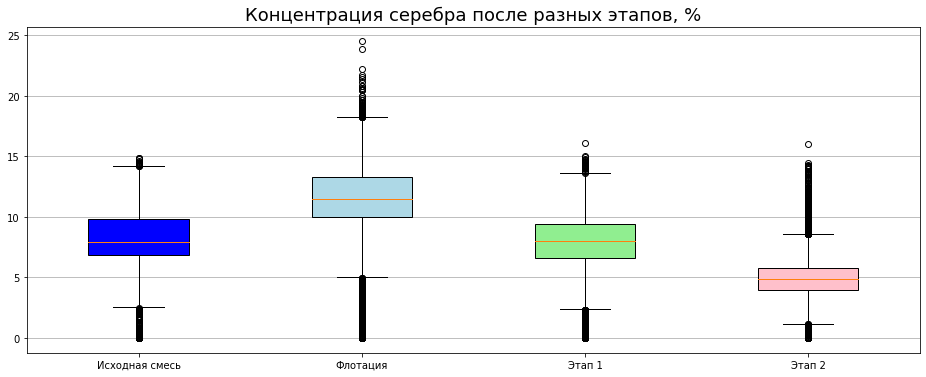

In [23]:
boxplot(data_ag, title_ag)

Концентрация серебра увеличивается после этапа флотации, а на последующих этапах снижается

Построим диаграмму для свинца

In [24]:
data_pb = [df_train['rougher.input.feed_pb'], df_train['rougher.output.concentrate_pb'], df_train['primary_cleaner.output.concentrate_pb'], 
           df_train['final.output.concentrate_pb']]

title_pb = 'Концентрация свинца после разных этапов, %'

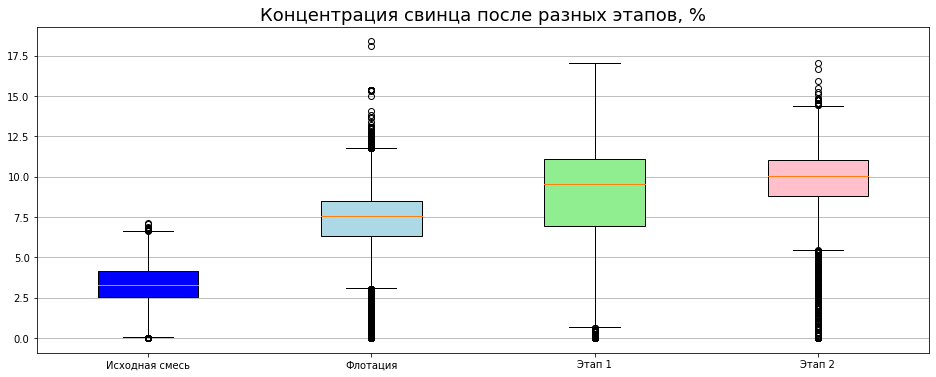

In [25]:
boxplot(data_pb, title_pb)

Концентрация свинца увеличивается на каждом этапе (после этапа очистки 2 практически не меняется)

## Анализ распределения размеров гранул сырья

Сравним распределения размеров гранул сырья до этапа флотации в тестовой и обучающей выборках  

Создадим функцию для построения распределений

In [26]:
def distribution_plot(data_1, data_2, title):
    
    plt.figure(figsize=(15, 5))
    
    sns.kdeplot(data_1, shade=True, color="b", label='Обучающая выборка', alpha=.5)
    
    sns.kdeplot(data_2, shade=True, color="y", label='Тестовая выборка', alpha=.5)

    plt.title(title, fontsize=18)
    
    plt.xlabel('Размер гранул сырья', fontsize=18)
    
    plt.ylabel('Доля, %', fontsize=18)
    
    plt.legend()
    
    plt.show()   
    

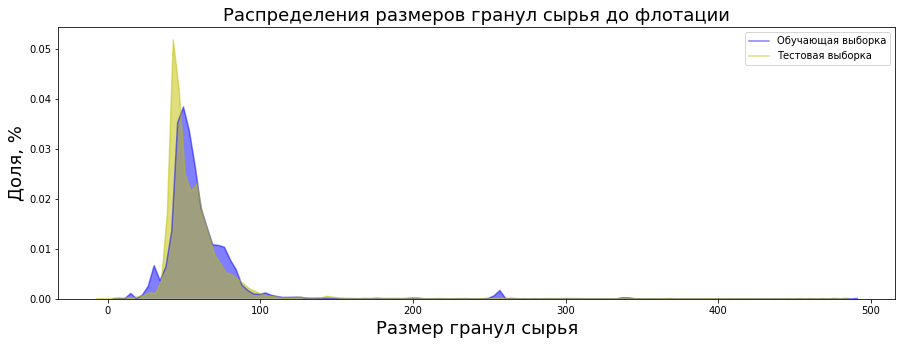

In [27]:
distribution_plot(df_train['rougher.input.feed_size'], df_test['rougher.input.feed_size'], 'Распределения размеров гранул сырья до флотации')

- Распределения очень близки
- Заменты небольшие выбросы около значения 250

Сравним распределения размеров гранул сырья после этапа флотации в тестовой и обучающей выборках

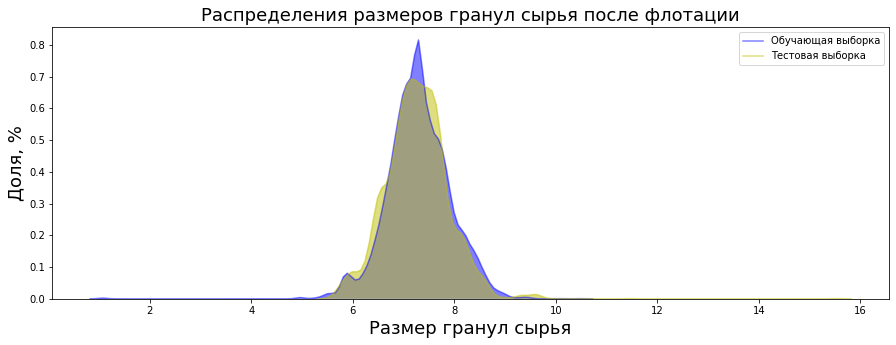

In [28]:
distribution_plot(df_train['primary_cleaner.input.feed_size'], df_test['primary_cleaner.input.feed_size'], 'Распределения размеров гранул сырья после флотации')

Распределения очень близки

Удалим из тестовой и обучающей выборок строки с размером гранул сырья, превышающем 200

In [29]:
df_train = df_train[df_train['rougher.input.feed_size'] <= 200]

df_test = df_test[df_test['rougher.input.feed_size'] <= 200]

## Анализ суммарной концентрации всех веществ на разных стадиях

Создадим функцию для вывода гистограммы распределения

In [30]:
def plot_hist(data, bins, min, max, title):
    
    plt.title(title, fontsize=18)
    
    plt.ylabel('Количество, шт.', fontsize=18)
    
    plt.xlabel('Концентрация, %', fontsize=18)
    
    data.hist(bins=bins, range = (min, max), figsize = (15, 5))

Построим гистограмму распределения для исходного сырья в обучающей выборке

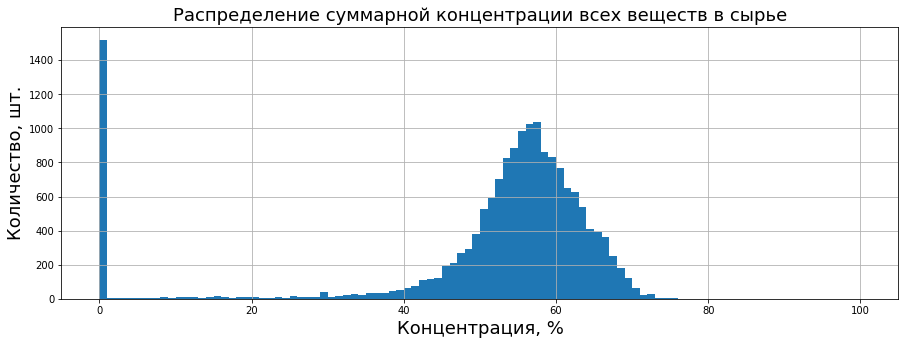

In [31]:
plot_hist(df_train['rougher.input.feed_au'] + df_train['rougher.input.feed_ag'] +
         df_train['rougher.input.feed_pb'] + df_train['rougher.input.feed_sol'],
         100, 0, 100, 'Распределение суммарной концентрации всех веществ в сырье')

Внимательнее посмотрим на выброс около 0

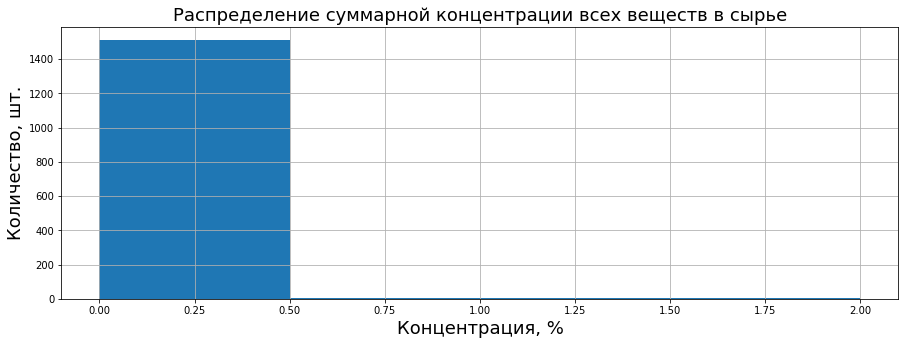

In [32]:
plot_hist(df_train['rougher.input.feed_au'] + df_train['rougher.input.feed_ag'] +
         df_train['rougher.input.feed_pb'] + df_train['rougher.input.feed_sol'],
         4, 0, 2, 'Распределение суммарной концентрации всех веществ в сырье')

Удалим строки из обучающей выборки, где какая-нибудь из концентраций менее 0.5%

In [33]:
df_train = df_train[(df_train['rougher.input.feed_au'] > 0.5) | (df_train['rougher.input.feed_ag'] > 0.5) | (df_train['rougher.input.feed_pb'] > 0.5) | (df_train['rougher.input.feed_sol'] > 0.5)]

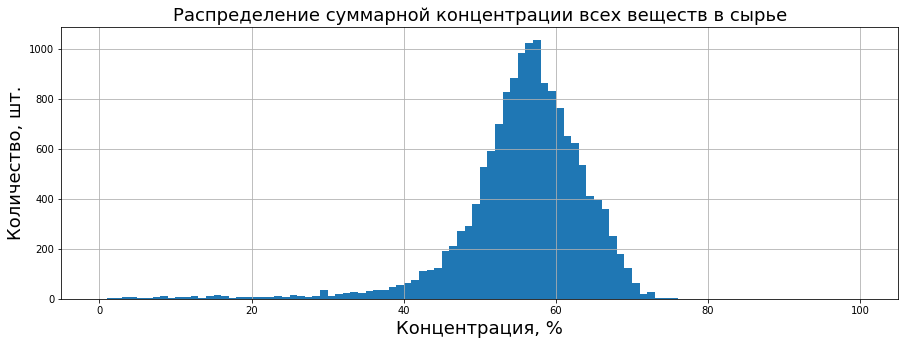

In [34]:
plot_hist(df_train['rougher.input.feed_au'] + df_train['rougher.input.feed_ag'] +
         df_train['rougher.input.feed_pb'] + df_train['rougher.input.feed_sol'],
         100, 0, 100, 'Распределение суммарной концентрации всех веществ в сырье')

Построим гистограмму распределения для чернового концентрата в обучающей выборке

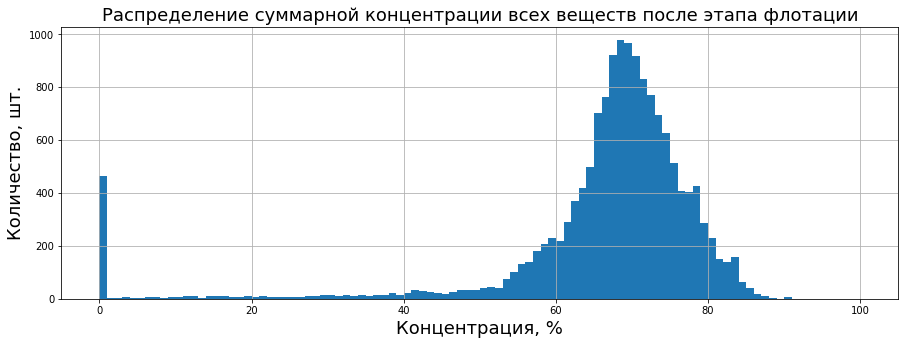

In [35]:
plot_hist(df_train['rougher.output.concentrate_ag'] + df_train['rougher.output.concentrate_au'] +
         df_train['rougher.output.concentrate_pb'] + df_train['rougher.output.concentrate_sol'],
         100, 0, 100, 'Распределение суммарной концентрации всех веществ после этапа флотации')

Внимательнее посмотрим на выброс около 0

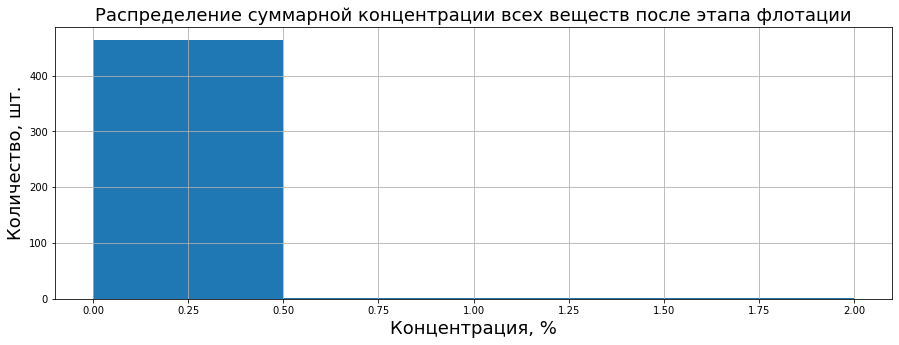

In [36]:
plot_hist(df_train['rougher.output.concentrate_ag'] + df_train['rougher.output.concentrate_au'] +
         df_train['rougher.output.concentrate_pb'] + df_train['rougher.output.concentrate_sol'],
         4, 0, 2, 'Распределение суммарной концентрации всех веществ после этапа флотации')

Удалим строки из обучающей выборки, где какая-нибудь из концентраций менее 0.5%

In [37]:
df_train = df_train[(df_train['rougher.output.concentrate_au'] > 0.5) | (df_train['rougher.output.concentrate_ag'] > 0.5) | (df_train['rougher.output.concentrate_pb'] > 0.5) | (df_train['rougher.output.concentrate_sol'] > 0.5)]

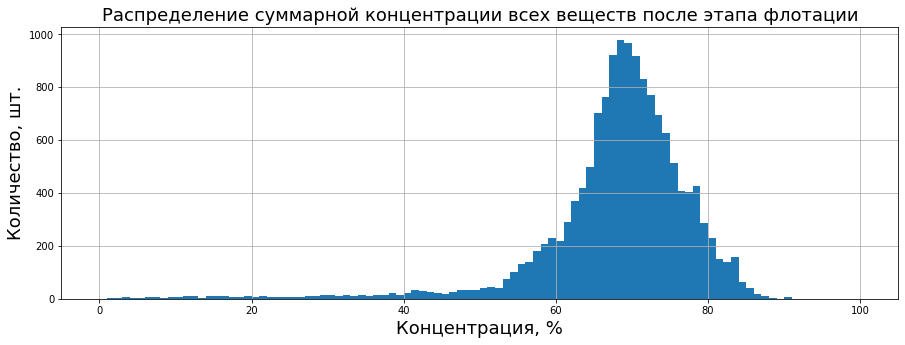

In [38]:
plot_hist(df_train['rougher.output.concentrate_ag'] + df_train['rougher.output.concentrate_au'] +
         df_train['rougher.output.concentrate_pb'] + df_train['rougher.output.concentrate_sol'],
         100, 0, 100, 'Распределение суммарной концентрации всех веществ после этапа флотации')

Построим гистограмму распределения для концентрата после этапа очистки 1 в обучающей выборке

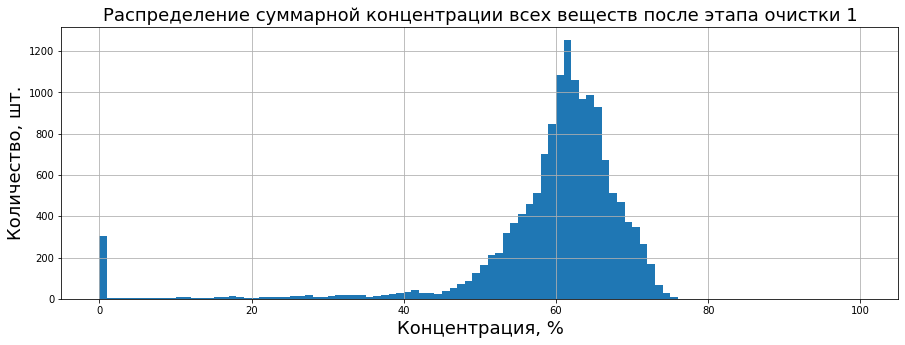

In [39]:
plot_hist(df_train['primary_cleaner.output.concentrate_ag'] + df_train['primary_cleaner.output.concentrate_au'] +
         df_train['primary_cleaner.output.concentrate_pb'] + df_train['primary_cleaner.output.concentrate_sol'],
         100, 0, 100, 'Распределение суммарной концентрации всех веществ после этапа очистки 1')

Внимательнее посмотрим на выброс около 0

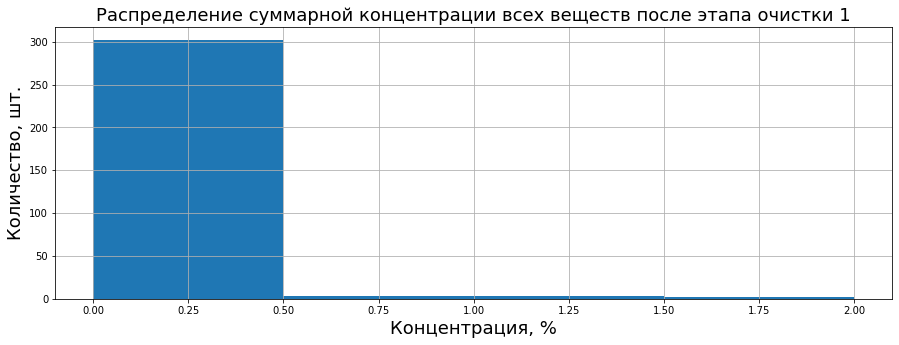

In [40]:
plot_hist(df_train['primary_cleaner.output.concentrate_ag'] + df_train['primary_cleaner.output.concentrate_au'] +
         df_train['primary_cleaner.output.concentrate_pb'] + df_train['primary_cleaner.output.concentrate_sol'],
         4, 0, 2, 'Распределение суммарной концентрации всех веществ после этапа очистки 1')

Удалим строки из обучающей выборки, где какая-нибудь из концентраций менее 0.5%

In [41]:
df_train = df_train[(df_train['primary_cleaner.output.concentrate_au'] > 0.5) | (df_train['primary_cleaner.output.concentrate_ag'] > 0.5) | (df_train['primary_cleaner.output.concentrate_pb'] > 0.5) | (df_train['primary_cleaner.output.concentrate_sol'] > 0.5)]

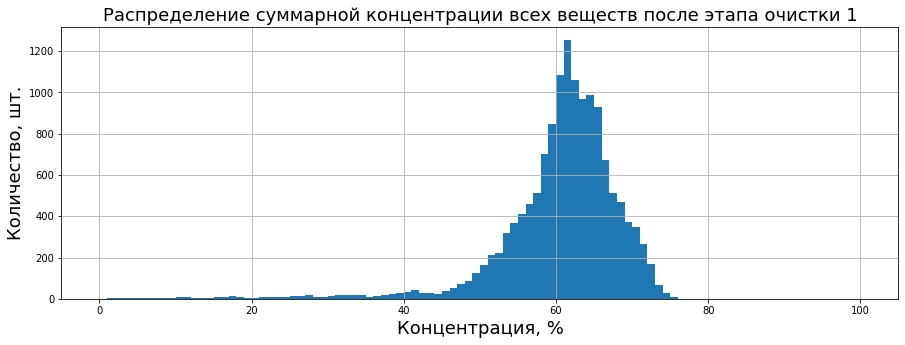

In [42]:
plot_hist(df_train['primary_cleaner.output.concentrate_ag'] + df_train['primary_cleaner.output.concentrate_au'] +
         df_train['primary_cleaner.output.concentrate_pb'] + df_train['primary_cleaner.output.concentrate_sol'],
         100, 0, 100, 'Распределение суммарной концентрации всех веществ после этапа очистки 1')

Построим гистограмму распределения для финального концентрата в обучающей выборке

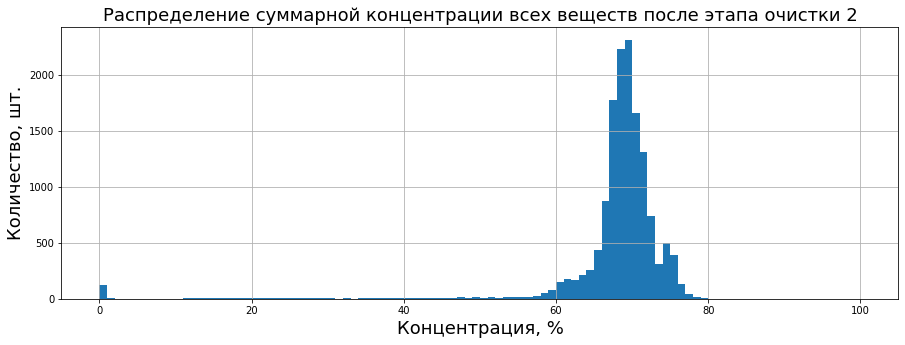

In [43]:
plot_hist(df_train['final.output.concentrate_ag'] + df_train['final.output.concentrate_au'] +
         df_train['final.output.concentrate_pb'] + df_train['final.output.concentrate_sol'],
         100, 0, 100, 'Распределение суммарной концентрации всех веществ после этапа очистки 2')

Внимательнее посмотрим на выброс около 0

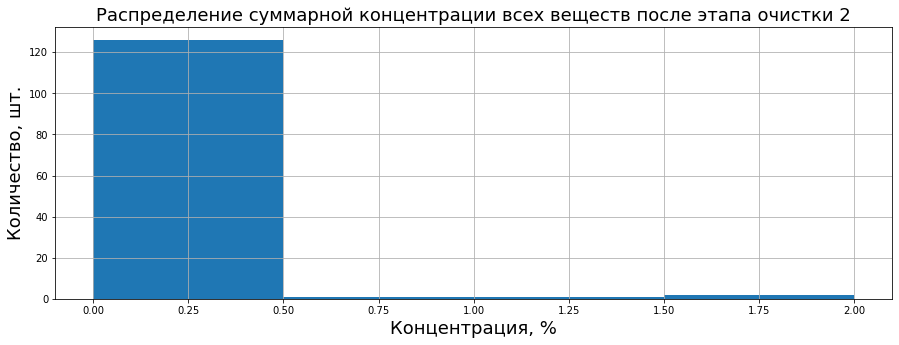

In [44]:
plot_hist(df_train['final.output.concentrate_ag'] + df_train['final.output.concentrate_au'] +
         df_train['final.output.concentrate_pb'] + df_train['final.output.concentrate_sol'],
         4, 0, 2, 'Распределение суммарной концентрации всех веществ после этапа очистки 2')


Удалим строки из обучающей выборки, где какая-нибудь из концентраций менее 0.5%

In [45]:
df_train = df_train[(df_train['final.output.concentrate_au'] > 0.5) | (df_train['final.output.concentrate_ag'] > 0.5) | (df_train['final.output.concentrate_pb'] > 0.5) | (df_train['final.output.concentrate_sol'] > 0.5)]

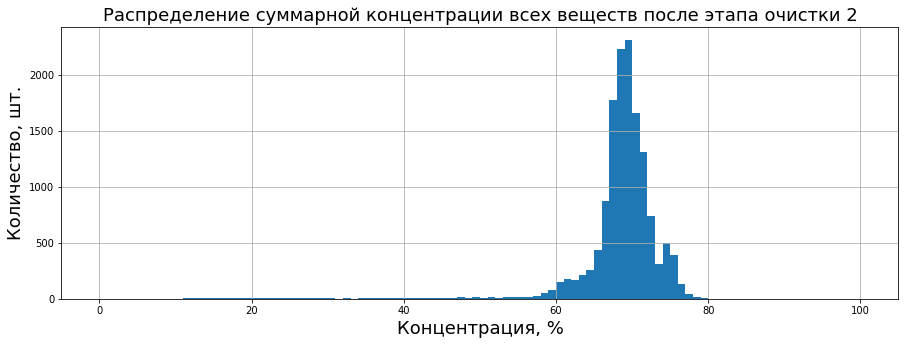

In [46]:
plot_hist(df_train['final.output.concentrate_ag'] + df_train['final.output.concentrate_au'] +
         df_train['final.output.concentrate_pb'] + df_train['final.output.concentrate_sol'],
         100, 0, 100, 'Распределение суммарной концентрации всех веществ после этапа очистки 2')

Построим гистограмму распределения для исходного сырья в тестовой выборке

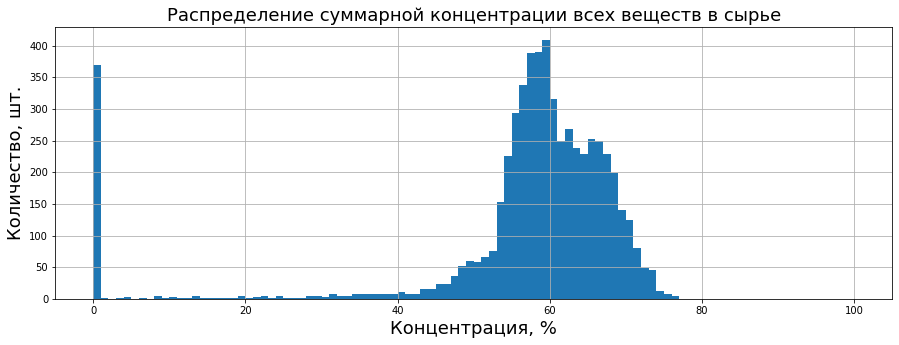

In [47]:
plot_hist(df_test['rougher.input.feed_au'] + df_test['rougher.input.feed_ag'] +
         df_test['rougher.input.feed_pb'] + df_test['rougher.input.feed_sol'],
         100, 0, 100, 'Распределение суммарной концентрации всех веществ в сырье')

Внимательнее посмотрим на выброс около 0

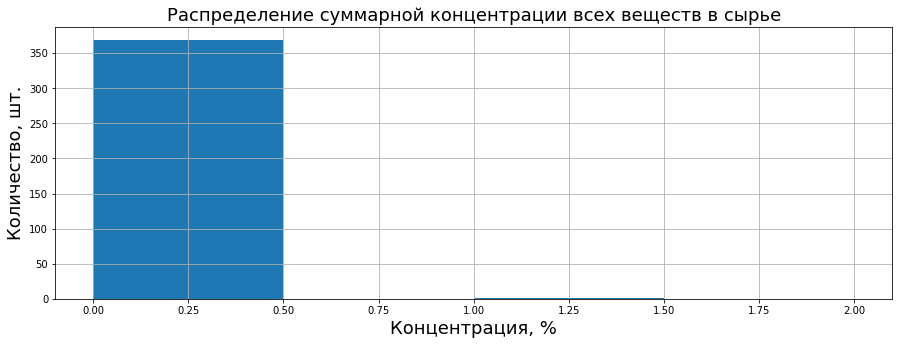

In [48]:
plot_hist(df_test['rougher.input.feed_au'] + df_test['rougher.input.feed_ag'] +
         df_test['rougher.input.feed_pb'] + df_test['rougher.input.feed_sol'],
         4, 0, 2, 'Распределение суммарной концентрации всех веществ в сырье')


Удалим строки из тестовой выборки, где какая-нибудь из концентраций менее 0.5%

In [49]:
df_test = df_test[(df_test['rougher.input.feed_au'] > 0.5) | (df_test['rougher.input.feed_ag'] > 0.5) | (df_test['rougher.input.feed_pb'] > 0.5) | (df_test['rougher.input.feed_sol'] > 0.5)]

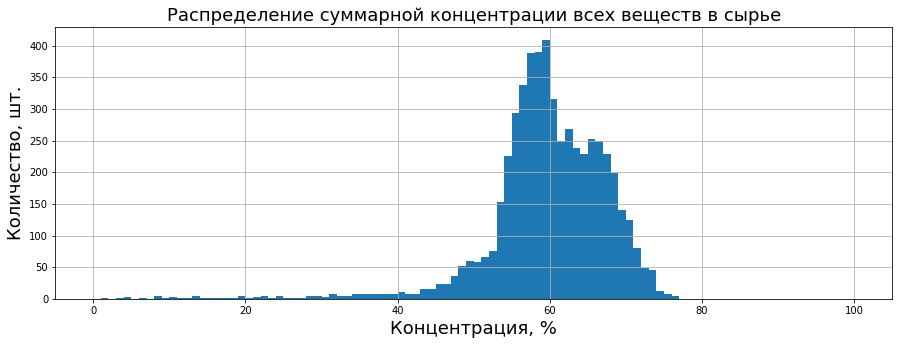

In [50]:
plot_hist(df_test['rougher.input.feed_au'] + df_test['rougher.input.feed_ag'] +
         df_test['rougher.input.feed_pb'] + df_test['rougher.input.feed_sol'],
         100, 0, 100, 'Распределение суммарной концентрации всех веществ в сырье')

## Выводы

- Концентрация золота с каждым этапом увеличивается
- Распределения размеров гранул сырья в обучающей и тестовой выборках практически идентичны
- Обучабщая и тестовая выборки очищены от довольно большого числа аномальномалых концентраций веществ

# Модель

## Функция для вычисления итоговой sMAPE

Создадим функцию для вычисления итоговой sMAPE

In [51]:
def smape_func(y_true_1, y_pred_1, y_true_2, y_pred_2):
    
    total_1, total_2 = 0, 0
    
    for i in range(len(y_true_1)):
        
        total_1 += (abs(y_true_1[i] - y_pred_1[i])) / ((abs(y_true_1[i]) + abs(y_pred_1[i])) / 2)
        
        result_1 = 100 * total_1 / len(y_true_1)
        
        total_2 += (abs(y_true_2[i] - y_pred_2[i])) / ((abs(y_true_2[i]) + abs(y_pred_2[i])) / 2)
        
        result_2 = 100 * total_2 / len(y_true_2)
                   
    return 0.25 * result_1 + 0.75 * result_2


Создадим функцию для вычисления sMAPE для использования выбора лучших гиперпараметров в модели

In [52]:
def smape(y_true, y_pred):
    
    total = 0
    
    for i in range(len(y_true)):
        
        total += (abs(y_true[i] - y_pred[i])) / ((abs(y_true[i]) + abs(y_pred[i])) / 2)
        
        result = 100 * total / len(y_true)
                   
    return result

## Обучение и выбор лучшей модели, её проверка на тестовой выборке

Удалим из списка названия столбцов тестовой выборки название `date`, т.к. этот столбец не является признаком для обучения

In [53]:
names_test = names_test.delete(0)

Создадим функцию, устанавливающую столбец `date` в качестве индекса выборки

In [54]:
def set_index_date(data):
    
    data = data.set_index('date', inplace=True)

Применим функцию ко всем выборкам

In [55]:
set_index_date(df_test)

set_index_date(df_train)

set_index_date(df_full)

Сохраним целевые признаки и признаки обучающей выборки

In [56]:
target_train_rougher = df_train['rougher.output.recovery'] # Целевой признак 1 (эффективность обогащения после флотации)

target_train_final = df_train['final.output.recovery'] # Целевой признак 2 (эффективность обогащения финальная) 

features_train = df_train[names_test]  # Признаки

Выполним масштабирование признаков обучающей выборки

In [57]:
scaler = StandardScaler()

scaler.fit(features_train)

features_train[names_test] = scaler.transform(features_train[names_test])

Создадим функцию для подбора лучших гиперпараметров по метрике sMAPE на основе GridSearchCV

In [58]:
 my_scorer = make_scorer(smape, greater_is_better=False)

In [59]:
def best_model(model, features, target, param_grid):
    
    model = model()
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=my_scorer)

    grid_search.fit(features, target)
    
    best_params = grid_search.best_params_
    
    best_score = grid_search.best_score_
    
    return best_params, best_score

Для этапа флотации будем применять только те признаки, которые относятся к этому этапу, т.к. другие по логике не должны быть доступны на данном этапе технологического процесса

In [60]:
features_train_rougher = features_train[names_test[12:33]]

Обучим модель линейной регрессии для эффективности обогащения этапа флотации

In [61]:
param_grid = {'n_jobs': [-1]}

best_params_lr_1, best_score_lr_1 = best_model(LinearRegression, features_train_rougher, target_train_rougher, param_grid)

print('Лучшая sMAPE:', -best_score_lr_1)

Лучшая sMAPE: 7.509466360555894


Обучим модель линейной регрессии для эффективности обогащения финальной

In [62]:
best_params_lr_2, best_score_lr_2 = best_model(LinearRegression, features_train, target_train_final, param_grid)

print('Лучшая sMAPE:', -best_score_lr_2)

Лучшая sMAPE: 11.370299082173162


Обучим модель случайного леса для эффективности обогащения этапа флотации

In [63]:
param_grid = {'n_estimators': [10, 20, 30, 40], 'max_depth': [5, 10, 15, 20], 'n_jobs': [-1], 'random_state': [12345]}

In [66]:
best_params_rf_1, best_score_rf_1 = best_model(RandomForestRegressor, features_train_rougher, target_train_rougher, param_grid)

print('Лучшие гиперпараметры:', best_params_rf_1)
print()
print('Лучшая sMAPE:', -best_score_rf_1)

Лучшие гиперпараметры: {'max_depth': 5, 'n_estimators': 20, 'n_jobs': -1, 'random_state': 12345}

Лучшая sMAPE: 7.411452806313602


Обучим модель случайного леса для эффективности обогащения финальной

In [67]:
param_grid = {'n_estimators': [10, 20, 30, 40], 'max_depth': [5, 10, 15, 20], 'n_jobs': [-1], 'random_state': [12345]}

In [68]:
best_params_rf_2, best_score_rf_2 = best_model(RandomForestRegressor, features_train, target_train_final, param_grid)

print('Лучшие гиперпараметры:', best_params_rf_2)
print()
print('Лучшая sMAPE:', -best_score_rf_2)

Лучшие гиперпараметры: {'max_depth': 5, 'n_estimators': 40, 'n_jobs': -1, 'random_state': 12345}

Лучшая sMAPE: 9.376244818830736


Модели случайного леса показали лучшие результаты. Именно их и будем использовать для финальных моделей

Дополним тестовую выборку целевыми признаками

In [69]:
df_test['rougher.output.recovery'] = df_full['rougher.output.recovery']

df_test['final.output.recovery'] = df_full['final.output.recovery']

Сохраним целевые признаки и признаки тестовой выборки

In [70]:
target_test_rougher = df_test['rougher.output.recovery'] # Целевой признак 1 (эффективность обогащения после флотации)

target_test_final = df_test['final.output.recovery'] # Целевой признак 2 (эффективность обогащения финальная)

features_test = df_test[names_test]

Масштабируем признаки тестовой выборки

In [71]:
features_test[names_test] = scaler.transform(features_test[names_test])

Для этапа флотации будем применять только те признаки, которые относятся к этому этапу

In [72]:
features_test_rougher = features_test[names_test[12:33]]

Обучим финальные модели случайного леса с лучшими гиперпараметрами 

In [73]:
model_rougher = RandomForestRegressor(n_estimators=best_params_rf_1['n_estimators'], max_depth=best_params_rf_1['max_depth'], n_jobs=-1, random_state=12345)

model_rougher.fit(features_train_rougher, target_train_rougher)

predictions_rougher = model_rougher.predict(features_test_rougher)                                      

In [74]:
model_final = RandomForestRegressor(n_estimators=best_params_rf_2['n_estimators'], max_depth=best_params_rf_2['max_depth'], n_jobs=-1, random_state=12345)

model_final.fit(features_train, target_train_final)

predictions_final = model_final.predict(features_test) 

Создадим функцию для преобразованя в `array`

In [75]:
def df_to_ar(data):
    
    return data.to_numpy()

Преобразуем целевые признаки тестовой выборки в `array`

In [76]:
target_test_rougher_ar = df_to_ar(target_test_rougher)

target_test_final_ar = df_to_ar(target_test_final)

Рассчитаем итоговую sMAPE

In [77]:
smape = smape_func(target_test_rougher_ar, predictions_rougher, target_test_final_ar, predictions_final)

smape

11.261038918962361

## Проверка адекватности модели

Обучим модель глупого регрессора и получим её предсказания для эффективности обогащения этапа флотации

In [78]:
dummy_regr = DummyRegressor(strategy="mean")

dummy_regr.fit(features_train_rougher, target_train_rougher)

predictions_rougher_dummy = dummy_regr.predict(features_test_rougher)

Обучим модель глупого регрессора и получим её предсказания для эффективности обогащения финальной

In [79]:
dummy_regr.fit(features_train, target_train_final)

predictions_final_dummy = dummy_regr.predict(features_test)

Рассчитаем итоговую sMAPE для моделей глупого регрессора 

In [80]:
smape_dummy = smape_func(target_test_rougher_ar, predictions_rougher_dummy, target_test_final_ar, predictions_final_dummy)

smape_dummy

10.982769383497525

## Выводы

- Модели случайного леса и линейной регресси на обучающей выборке показали примерно одинаковые результаты
- Финальная модель случайного леса на тестовой выборке имеет sMAPE = 11,3%, схожую с моделью глупого регрессора, что говорит о невысоком качестве полученной модели